In [1]:
import holoocean
import numpy as np
import json
import math
import sys
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import operator

from IPython.display import display
from IPython.display import clear_output
import IPython

import octomap
import plotly.io as pio

In [2]:
with open("./config_2.json", 'r') as f:
    cfg = json.load(f)

In [3]:
config = cfg['agents'][0]['sensors'][-1]["configuration"]
azi = config["Azimuth"]
ele = config["Elevation"]
minR = config["RangeMin"]
maxR = config['RangeMax']
binsR = config["RangeBins"]
binsA = config["AzimuthBins"]

In [4]:
phi = np.linspace(0, ele, binsR)*np.pi/180

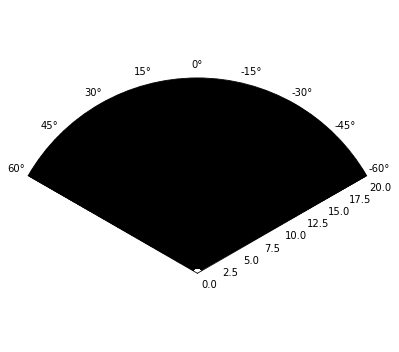

In [5]:
%matplotlib inline
plt.ion()
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8,5))
ax.set_theta_zero_location("N")
ax.set_thetamin(-azi/2)
ax.set_thetamax(azi/2)

theta = np.linspace(-azi/2, azi/2, binsA)*np.pi/180
r = np.linspace(minR, maxR, binsR)
T, R = np.meshgrid(theta, r)
P,_ = np.meshgrid(phi, r)
z = np.zeros_like(T)

plt.grid(False)
plot = ax.pcolormesh(T, R, z, cmap='gray', shading='auto', vmin=0, vmax=1)
plt.tight_layout()
fig.set_facecolor("w")
fig.canvas.flush_events()

In [6]:
resolution = 0.1
octree = octomap.OcTree(resolution)

In [7]:
env = holoocean.make(scenario_cfg=cfg)

In [8]:
action = np.zeros(8)
action[0:4] -= 65

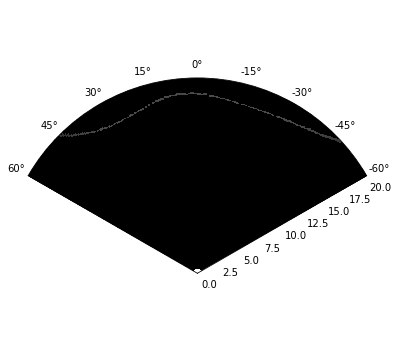

200

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

array([-16.96281], dtype=float32)

In [9]:
%matplotlib inline
states = env.tick()
env_map = []
for i in range(8):
    env.act('auv0', action)
    states = env.tick(num_ticks=20)
    clear_output()
    if 'ProfilingSonar' in states:
            s = states['ProfilingSonar']
            plot.set_array(s.ravel())
            fig.canvas.draw()
            fig.canvas.flush_events()
            display(fig)
    sonar = states["ProfilingSonar"]
    display(len(sonar))
    display(states["ProfilingSonar"])
    display(states["DepthSensor"])
#    display(action)

In [10]:
def get_coordinates(r, theta, phi, j):
#    return r * np.sin(theta) * np.sin(phi), r * np.sin(theta) * np.cos(phi), - r * np.cos(theta)
    return 0, r * np.sin(theta), -r * np.cos(theta) 

In [11]:
def get_coordinates_from_sonar_data(sonar_data, robot_coordinates, R=R, T=T, P=P):
    result = []
    for index_1, i in enumerate(sonar_data):
        if i.any():
            # array has at least one value other than zero
            for index_2, j in enumerate(i):
                if j == 0.: continue
                coords = get_coordinates(R[index_1][index_2], T[index_1][index_2], -1, j)
                result.append(tuple(map(operator.add, coords, robot_coordinates)))
    return result


In [12]:
action = np.zeros(8)
action[4:8] += 200

states = env.tick()
env_map = []

In [13]:
for i in range(16*15):
    env.act('auv0', action)
    states = env.tick()
    clear_output()
    if 'ProfilingSonar' in states:
            s = states['ProfilingSonar']
            coords = get_coordinates_from_sonar_data(s, (states["PoseSensor"][0][3], states["PoseSensor"][1][3], states["PoseSensor"][2][3]))
            octree.insertPointCloud(
                pointcloud=np.array(coords),
                origin=np.array([0,0,0], dtype=float) # we probably can also add the robot coordinates here
            )

In [14]:
surface, _ = octree.extractPointCloud()

In [15]:
with open("point_cloud_octomap.xyz", "w") as file:
    for x,y,z in surface:
        file.write("%f %f %f\n" % (x,y,z))

In [16]:
octree.writeBinary(str.encode("test.bt"))

True

In [17]:
octree_copy = octomap.OcTree(resolution)
octree_copy.readBinary(str.encode("test.bt"))

True

In [18]:
surface_copy, _ = octree_copy.extractPointCloud()

In [19]:
surface.shape

(72199, 3)

In [20]:
surface_copy.shape

(72199, 3)